In [168]:
from path import Path
import json
from itertools import chain

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [79]:
REACT_ISSUES_DIR_PATH = Path('react_issues/')


issues = []

for issue_path in REACT_ISSUES_DIR_PATH.glob('*.json'):
    with issue_path.open() as issue_file:
        issue_properties = json.load(issue_file)
        issues.append((
            issue_properties['title'], 
            issue_properties['body'], 
            issue_properties['user'], 
            issue_properties['has_pr'], 
            issue_properties['labels']
        ))

issues = pd.DataFrame.from_records(issues, columns=['title', 'body', 'user', 'pr', 'labels'])
issues['body'] = issues['body'].fillna('')
train_issues, val_issues = train_test_split(issues)

In [92]:
COMPONENT_PREFIX = 'Component: '


all_labels = set(chain(*issues['labels']))
component_labels = [issue for issue in all_issues if issue.startswith(COMPONENT_PREFIX)]

In [71]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer


stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer(language='english')


def extract_tokens(string):
    tokens = word_tokenize(string)
    return [
        stemmer.stem(token.lower())
        for token in word_tokenize(string)
        if token.isalpha() and token not in stop_words
    ]

In [110]:
def extract_targets(subset):
    return [
        np.float32([target_label in issue_labels for issue_labels in subset['labels']])
        for target_label in component_labels
    ]

train_targets = extract_targets(train_issues)
val_targets = extract_targets(val_issues)

In [176]:
for label, values in zip(component_labels, train_targets):
    print(f'Positive share for {label:40}: {values.mean():.6f}')

Positive share for Component: Suspense                     : 0.001563
Positive share for Component: Test Utils                   : 0.003263
Positive share for Component: Developer Tools              : 0.019848
Positive share for Component: Component API                : 0.001359
Positive share for Component: Server Rendering             : 0.002787
Positive share for Component: ReactIs                      : 0.000068
Positive share for Component: Test Renderer                : 0.001223
Positive share for Component: DOM                          : 0.024674
Positive share for Component: Fast Refresh                 : 0.000068
Positive share for Component: Flight                       : 0.000000
Positive share for Component: Hooks                        : 0.002719
Positive share for Component: ESLint Rules                 : 0.002719
Positive share for Component: Reconciler                   : 0.003467
Positive share for Component: Scheduler                    : 0.000272
Positive share for C

Very few examples are positive for each label, class weights are required.

In [180]:
train_users = set(train_issues['user'])
val_users = set(val_issues['user'])
len(train_users), len(val_users), len(train_users & val_users)

(6368, 2589, 949)

Sets of users differ too much between the training and testing datasets.

In [169]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder


feature_extractor = ColumnTransformer([
    ('title_vectorizer', TfidfVectorizer(analyzer=extract_tokens), 'title'),
    ('body_vectorizer', TfidfVectorizer(analyzer=extract_tokens), 'body')
])

In [170]:
train_features = feature_extractor.fit_transform(train_issues)
val_features = feature_extractor.transform(val_issues)

In [257]:
metrics_table_columns = ['label', 'precision', 'recall', 'f1']

def train_classifiers(model_factory):
    models, metrics = [], []
    for target_label, train_target, val_target in zip(component_labels, train_targets, val_targets):
        try:
            model = model_factory()
            model.fit(train_features, train_target)
            models.append(model)
            
            train_pred = model.predict(train_features)
            train_prec = precision_score(train_target, train_pred, zero_division=0)
            train_rec = recall_score(train_target, train_pred, zero_division=0)
            train_f1 = f1_score(train_target, train_pred, zero_division=0)

            val_pred = model.predict(val_features)
            val_prec = precision_score(val_target, val_pred, zero_division=0)
            val_rec = recall_score(val_target, val_pred, zero_division=0)
            val_f1 = f1_score(val_target, val_pred, zero_division=0)
            metrics.append([target_label, val_prec, val_rec, val_f1])
            print(f'{train_prec:.3f} {train_rec:.3f} {train_f1:.3f} {val_prec:.3f} {val_rec:.3f} {val_f1:.3f}')
        except Exception as e:
            print(f'Error training for "{target_label}": {e}')
            models.append(None)
            metrics.append((target_label, 0., 0., 0.))
    metrics = pd.DataFrame.from_records(metrics, columns=metrics_table_columns)
    return models, metrics

In [273]:
from sklearn.linear_model import LogisticRegression


log_reg_model, log_reg_metrics = train_classifiers(
    lambda: LogisticRegression(penalty='l2', C=.05, class_weight={0.: 1, 1.: 100}))

0.469 1.000 0.639 0.083 0.200 0.118
0.565 1.000 0.722 0.211 0.286 0.242
0.487 1.000 0.655 0.432 0.872 0.577
1.000 1.000 1.000 0.000 0.000 0.000
0.350 1.000 0.519 0.182 0.267 0.216
0.000 0.000 0.000 0.000 0.000 0.000
0.692 1.000 0.818 0.000 0.000 0.000
0.140 1.000 0.245 0.120 0.821 0.209
0.000 0.000 0.000 0.000 0.000 0.000
Error training for "Component: Flight": This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0
0.305 0.975 0.464 0.085 0.235 0.125
0.421 1.000 0.593 0.206 0.636 0.311
0.662 1.000 0.797 0.000 0.000 0.000
1.000 1.000 1.000 0.000 0.000 0.000
0.585 1.000 0.738 0.067 0.091 0.077
0.739 1.000 0.850 0.500 0.333 0.400
1.000 1.000 1.000 1.000 0.500 0.667
1.000 1.000 1.000 1.000 0.500 0.667
0.358 1.000 0.528 0.188 0.600 0.286
0.176 1.000 0.299 0.090 0.453 0.150


In [276]:
from sklearn.svm import SVC


svm_model, svm_metrics = train_classifiers(lambda: SVC(C = .05, class_weight={0: .1, 1: 100}))

0.561 1.000 0.719 0.100 0.200 0.133
0.539 1.000 0.701 0.294 0.357 0.323
0.032 1.000 0.063 0.031 1.000 0.060
1.000 1.000 1.000 0.000 0.000 0.000
0.323 1.000 0.488 0.100 0.200 0.133
1.000 1.000 1.000 0.000 0.000 0.000
0.188 1.000 0.316 0.000 0.000 0.000
0.025 1.000 0.048 0.028 1.000 0.054
1.000 1.000 1.000 0.000 0.000 0.000
Error training for "Component: Flight": Class label 1 not present.
0.260 1.000 0.412 0.081 0.294 0.127
0.412 1.000 0.584 0.185 0.455 0.263
0.115 1.000 0.206 0.021 0.158 0.038
1.000 1.000 1.000 0.000 0.000 0.000
0.011 1.000 0.022 0.008 0.818 0.016
0.680 1.000 0.810 0.500 0.333 0.400
1.000 1.000 1.000 1.000 1.000 1.000
1.000 1.000 1.000 1.000 0.500 0.667
0.358 1.000 0.528 0.176 0.600 0.273
0.010 1.000 0.019 0.011 1.000 0.021


In [392]:
from catboost import CatBoostClassifier


gb_model, gb_metrics = train_classifiers(lambda: CatBoostClassifier(
    verbose=False, n_estimators=32, reg_lambda=100, class_weights=[0.1, 10]))

0.213 1.000 0.351 0.121 0.800 0.211
0.215 0.771 0.336 0.173 0.643 0.273
0.327 0.932 0.484 0.302 0.862 0.448
0.941 0.800 0.865 0.000 0.000 0.000
0.171 0.927 0.289 0.087 0.467 0.147
1.000 1.000 1.000 0.000 0.000 0.000
0.900 1.000 0.947 0.000 0.000 0.000
0.030 0.997 0.058 0.032 0.970 0.062
1.000 1.000 1.000 0.000 0.000 0.000
Error training for "Component: Flight": c:/program files (x86)/go agent/pipelines/buildmaster/catboost.git/catboost/private/libs/target/target_converter.cpp:376: Target contains only one unique value
0.086 0.875 0.156 0.069 0.588 0.124
0.153 0.900 0.262 0.088 0.727 0.157
0.500 0.569 0.532 0.000 0.000 0.000
1.000 1.000 1.000 0.000 0.000 0.000
0.234 0.514 0.322 0.015 0.045 0.022
0.557 1.000 0.716 0.200 0.500 0.286
0.857 1.000 0.923 1.000 0.500 0.667
0.294 1.000 0.455 0.167 0.500 0.250
0.253 1.000 0.404 0.125 0.600 0.207
0.055 0.819 0.102 0.031 0.415 0.058


In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

In [393]:
log_reg_metrics['model'] = 'Logistic Regression'
gb_metrics['model'] = 'Boosting'
svm_metrics['model'] = 'SVM'
all_metrics = pd.concat([log_reg_metrics, gb_metrics, svm_metrics])

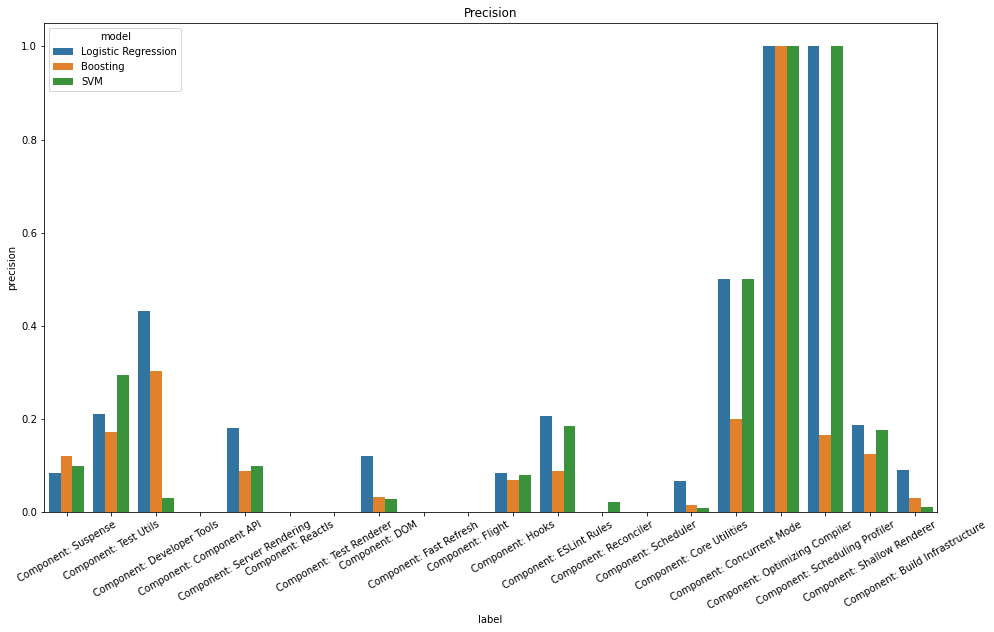

In [394]:
plt.figure(figsize=(16, 9))
prec_plot = sns.barplot(data=all_metrics, x='label', y='precision', hue='model')
prec_plot.set_title('Precision')
_ = prec_plot.set_xticklabels(prec_plot.get_xticklabels(), rotation=30)

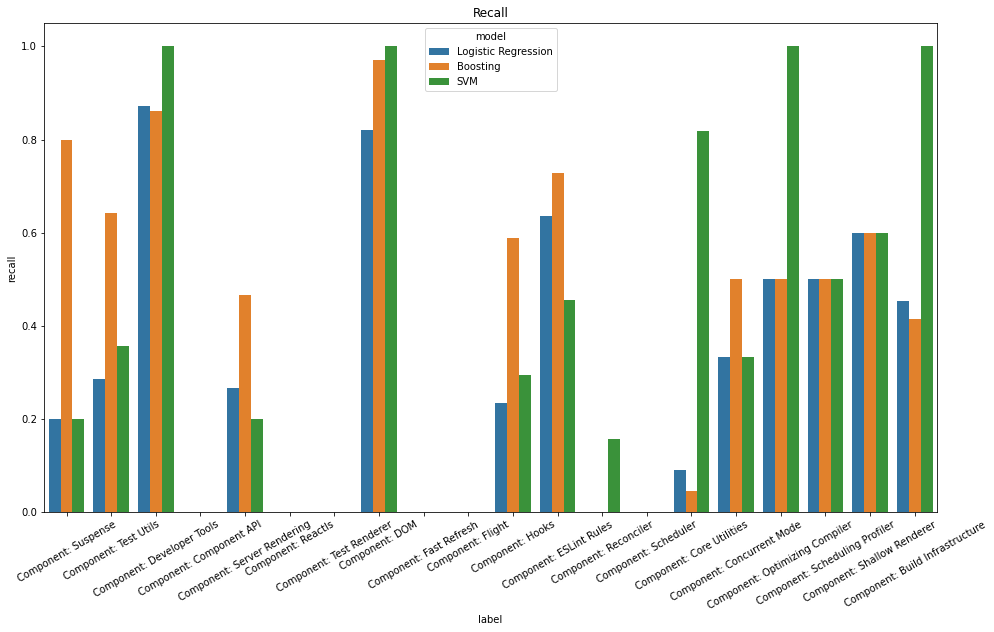

In [395]:
plt.figure(figsize=(16, 9))
prec_plot = sns.barplot(data=all_metrics, x='label', y='recall', hue='model')
prec_plot.set_title('Recall')
_ = prec_plot.set_xticklabels(prec_plot.get_xticklabels(), rotation=30)

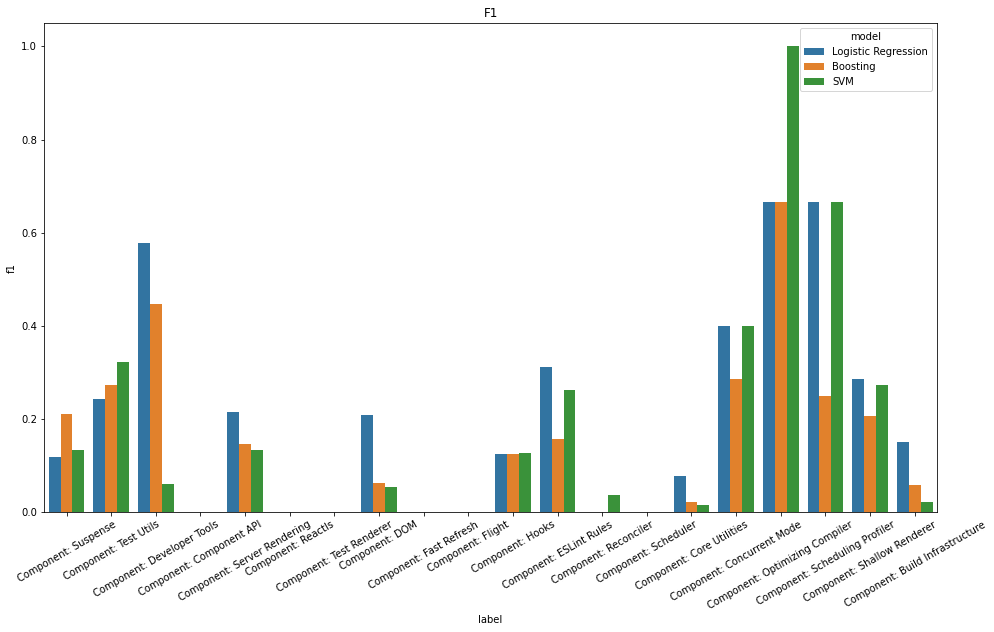

In [396]:
plt.figure(figsize=(16, 9))
prec_plot = sns.barplot(data=all_metrics, x='label', y='f1', hue='model')
prec_plot.set_title('F1')
_ = prec_plot.set_xticklabels(prec_plot.get_xticklabels(), rotation=30)